In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import altair as alt
import xgboost as xgb
import lightgbm as lgb
from math import sqrt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn import linear_model,preprocessing
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore")

# Ames Housing Data

In [2]:
#Reading input files to python dataframe
df_train_original = pd.read_csv('C:/Users/sampr/Desktop/Data mining assignments/Cmpe 255 Project/Milestone 3/New folder/ames_raw.csv', encoding='utf-8')
#If you want to run with school data, uncomment this line and run. Also uncomment the section in preprocessing col4.
#df_train_original = pd.read_csv('ames_raw - with schools.csv', encoding='utf-8')
df_test = pd.read_csv('C:/Users/sampr/Desktop/Data mining assignments/Cmpe 255 Project/Milestone 3/New folder/test.csv', encoding='utf-8')

### Preprocessing

In [3]:
#Initial preprocessing on input file
df_train = df_train_original
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_train.columns = df_train.columns.str.replace(' ', '')
df_train.rename(columns={"Order": "Id","YearRemod/Add":"YearRemodAdd"},inplace='True')
print("Shape of train data :",df_train.shape)
print("Shape of test data :",df_test.shape)

Shape of train data : (2930, 82)
Shape of test data : (1459, 80)


In [4]:
#Incorporating crime data
year = {2006: '222.0', 
           2007: '265.7', 
           2008: '247.4', 
           2009: '219.6', 
           2010: '217.1'} 
df_train['Crime Rate'] = df_train['YrSold'].map(year)
df_test['Crime Rate'] = df_test['YrSold'].map(year)

In [5]:
#Uncomment if you want to get results with income data. 
#Incorporating income data
# income_iowa = np.array([[2006, 54224], [2007, 56048], [2008,55902], [2009,55025], [2010,54038]])
# income_us = np.array([[2006, 59051], [2007, 60135], [2008,59382], [2009,57519], [2010,56388]])
# year_income_iowa = {2006: '54224', 
#            2007: '56048', 
#            2008: '55902', 
#            2009: '55025', 
#            2010: '54038'} 
# year_income_us = {2006: '59051', 
#            2007: '60135', 
#            2008: '59382', 
#            2009: '57519', 
#            2010: '56388'} 
# df_train['US Income'] = df_train['YrSold'].map(year_income_us)
# df_test['US Income'] = df_test['YrSold'].map(year_income_us)
# df_train['Iowa Income'] = df_train['YrSold'].map(year_income_iowa)
# df_test['Iowa Income'] = df_test['YrSold'].map(year_income_iowa)

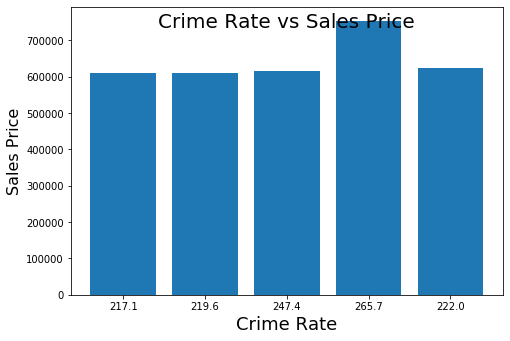

In [6]:
#Crime Rate Vs SalesPrice
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['Crime Rate'],df_train['SalePrice'])
fig.suptitle('Crime Rate vs Sales Price', fontsize=20)
plt.xlabel('Crime Rate', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

In [7]:
df_train.shape

(2930, 83)

In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2930.0,1.465500e+03,8.459625e+02,1.0,7.332500e+02,1465.5,2.197750e+03,2.930000e+03
PID,2930.0,7.144645e+08,1.887308e+08,526301100.0,5.284770e+08,535453620.0,9.071811e+08,1.007100e+09
MSSubClass,2930.0,5.738737e+01,4.263802e+01,20.0,2.000000e+01,50.0,7.000000e+01,1.900000e+02
LotFrontage,2440.0,6.922459e+01,2.336533e+01,21.0,5.800000e+01,68.0,8.000000e+01,3.130000e+02
LotArea,2930.0,1.014792e+04,7.880018e+03,1300.0,7.440250e+03,9436.5,1.155525e+04,2.152450e+05
OverallQual,2930.0,6.094881e+00,1.411026e+00,1.0,5.000000e+00,6.0,7.000000e+00,1.000000e+01
OverallCond,2930.0,5.563140e+00,1.111537e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.000000e+00
YearBuilt,2930.0,1.971356e+03,3.024536e+01,1872.0,1.954000e+03,1973.0,2.001000e+03,2.010000e+03
YearRemodAdd,2930.0,1.984267e+03,2.086029e+01,1950.0,1.965000e+03,1993.0,2.004000e+03,2.010000e+03
MasVnrArea,2907.0,1.018968e+02,1.791126e+02,0.0,0.000000e+00,0.0,1.640000e+02,1.600000e+03


In [9]:
df_train.dtypes

Id                 int64
PID                int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
                  ...   
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Crime Rate        object
Length: 83, dtype: object

Skewness of Data: 1.7435000757376466


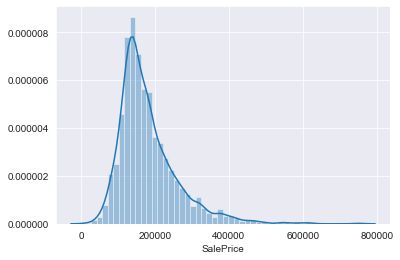

In [10]:
#Analyzing thw distribution of test variable  'SalePrice'
print("Skewness of Data:",format(df_train['SalePrice'].skew()))
sns.set_style('darkgrid')
sns.distplot(df_train['SalePrice'])

In [11]:
#Identifying the missing value columns in training data
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Missing Values in Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Missing Values in Total Values', ascending=False).round(1)
    #print(df.shape[1])
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns
missing_values_table(df_train)

Your selected dataframe has 83 columns.
There are 27 columns that have missing values.


,Missing Values,% of Missing Values in Total Values
PoolQC,2917,99.6
MiscFeature,2824,96.4
Alley,2732,93.2
Fence,2358,80.5
FireplaceQu,1422,48.5
LotFrontage,490,16.7
GarageCond,159,5.4
GarageQual,159,5.4
GarageFinish,159,5.4
GarageYrBlt,159,5.4


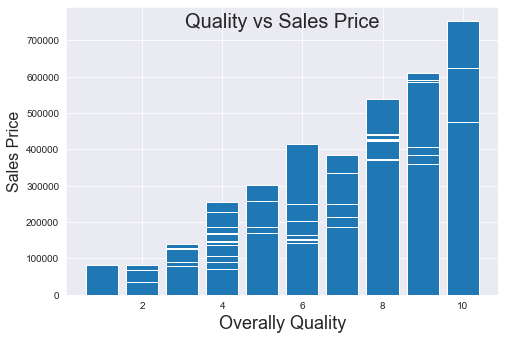

In [12]:
#Quality vs Sales Price
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['OverallQual'],df_train['SalePrice'])
fig.suptitle('Quality vs Sales Price', fontsize=20)
plt.xlabel('Overally Quality', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

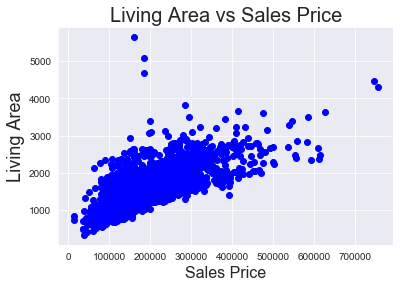

In [13]:
#Living Area vs Sales Price
plt.scatter(df_train['SalePrice'],df_train['GrLivArea'],c = 'blue')
plt.title('Living Area vs Sales Price', fontsize=20)
plt.ylabel('Living Area', fontsize=18)
plt.xlabel('Sales Price', fontsize=16)
plt.show()

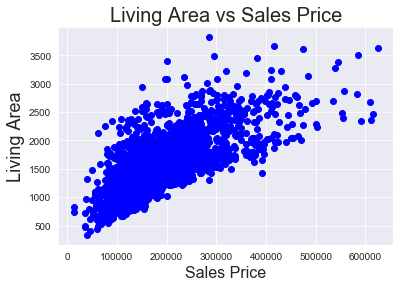

In [14]:
#Removing Outliers and Plotting
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index).reset_index(drop=True)
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']>700000)].index).reset_index(drop=True)
plt.scatter(df_train['SalePrice'],df_train['GrLivArea'],c = 'blue')
plt.title('Living Area vs Sales Price', fontsize=20)
plt.ylabel('Living Area', fontsize=18)
plt.xlabel('Sales Price', fontsize=16)
plt.show()

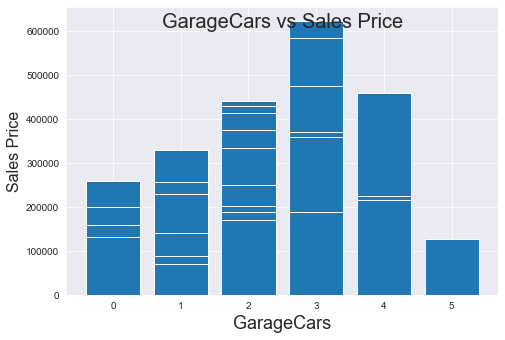

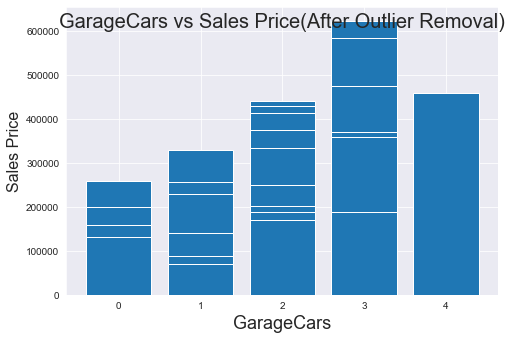

In [15]:
#Garage Cars Vs SalePrice
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['GarageCars'],df_train['SalePrice'])
fig.suptitle('GarageCars vs Sales Price', fontsize=20)
plt.xlabel('GarageCars', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()
#Removing outliers and plotting 
df_train = df_train.drop(df_train[(df_train['GarageCars']>3) & (df_train['SalePrice']<300000)].index).reset_index(drop=True)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['GarageCars'],df_train['SalePrice'])
fig.suptitle('GarageCars vs Sales Price(After Outlier Removal)', fontsize=20)
plt.xlabel('GarageCars', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

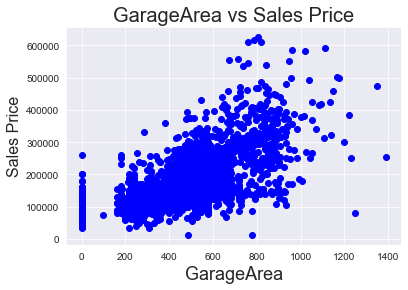

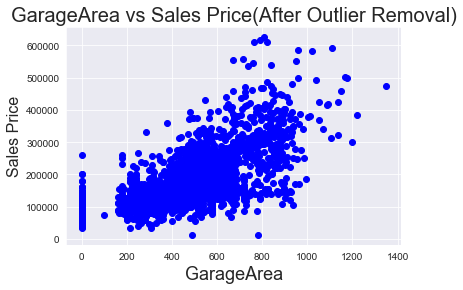

In [16]:
#GarageArea vs SalesPrice
plt.scatter(df_train['GarageArea'],df_train['SalePrice'],c = 'blue')
plt.title('GarageArea vs Sales Price', fontsize=20)
plt.xlabel('GarageArea', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()
# Removing outliers and plotting 
df_train = df_train.drop(df_train[(df_train['GarageArea']>1000) & (df_train['SalePrice']<300000)].index).reset_index(drop=True)
plt.scatter(df_train['GarageArea'],df_train['SalePrice'],c = 'blue')
plt.title('GarageArea vs Sales Price(After Outlier Removal)', fontsize=20)
plt.xlabel('GarageArea', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

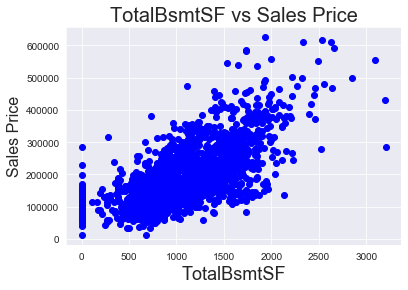

In [17]:
#Basement Area Vs SalePrice

plt.scatter(df_train['TotalBsmtSF'],df_train['SalePrice'],c = 'blue')
plt.title('TotalBsmtSF vs Sales Price', fontsize=20)
plt.xlabel('TotalBsmtSF', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

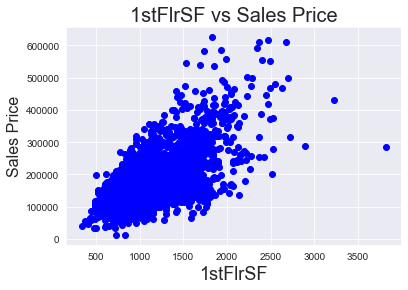

In [18]:
#1stFloorArea Vs SalePrice
plt.scatter(df_train['1stFlrSF'],df_train['SalePrice'],c = 'blue')
plt.title('1stFlrSF vs Sales Price', fontsize=20)
plt.xlabel('1stFlrSF', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

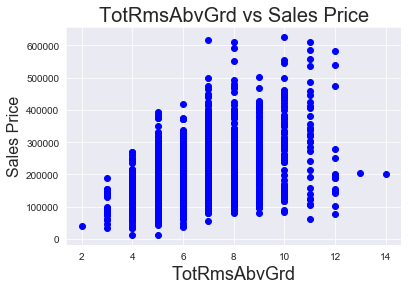

In [19]:
#Total Rooms Vs SalePrice
plt.scatter(df_train['TotRmsAbvGrd'],df_train['SalePrice'],c = 'blue')
plt.title('TotRmsAbvGrd vs Sales Price', fontsize=20)
plt.xlabel('TotRmsAbvGrd', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

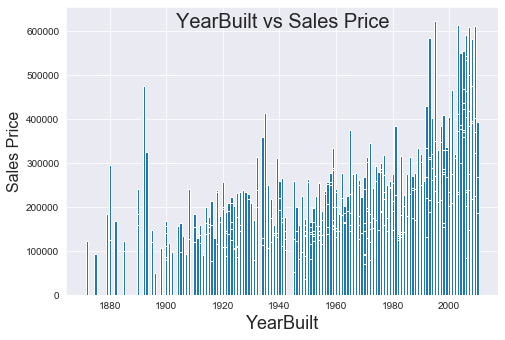

In [20]:
#YearBuilt Vs SalePrice
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['YearBuilt'],df_train['SalePrice'])
fig.suptitle('YearBuilt vs Sales Price', fontsize=20)
plt.xlabel('YearBuilt', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

In [21]:
#Reducing Skewness of test variable SalePrice
y = np.log(df_train.SalePrice).values

#Getting train and test shapes
df_train_shape = df_train.shape[0]
df_test_shape = df_test.shape[0]
test_ID=df_test['Id']

#Combining training and testing datasets.
df = pd.concat([df_train, df_test], axis=0, sort=False)
df.drop(['SalePrice','PID','Id'], axis=1, inplace=True)
df_shape=df.shape[0]

In [22]:
#Handling Missing Values

col1 = ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','GarageYrBlt', 'GarageArea','GarageCars','MasVnrArea')
col2 = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','Fence','PoolQC','MiscFeature','Alley','FireplaceQu','Fence','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
col3 = ['Utilities','Exterior1st','Exterior2nd','SaleType','Functional','Electrical','KitchenQual', 'GarageFinish', 'GarageQual', 'GarageCond','MasVnrType']
#col4 = ['Edwards','Fellows','Meeker','Mitchell' ,'Sawyer','Northwood' ,'Middle','High']
#Filling null values in col1 with 0
for col in col1:
    df[col] = df[col].fillna(0)

#Filling null values in col2 with None
for col in col2:
    df[col] = df[col].fillna('None')

#Filling null values in col3 with mode of that column
for col in col3:
    df[col] = df[col].fillna(df[col].mode()[0])
    
#Filling null values in col4 with 0
#for col in col4:
#    df[col] = df[col].fillna(0)
    
    
#Filling null values in below columns with median of that column
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#For rows where all neighborhood has null lotFrontage,fill 0
df['LotFrontage'] = df['LotFrontage'].fillna(0)

#Filling null values in below columns with mode of that column
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))



In [23]:
missing_values_table(df)

Your selected dataframe has 80 columns.
There are 0 columns that have missing values.


,Missing Values,% of Missing Values in Total Values


In [24]:
#finding correlation between features
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [25]:
# Attributes having maximum correlation to sales price
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.805541
GrLivArea        0.720571
GarageCars       0.666318
GarageArea       0.663508
TotalBsmtSF      0.659867
1stFlrSF         0.645029
YearBuilt        0.565761
FullBath         0.544381
YearRemodAdd     0.538697
GarageYrBlt      0.533860
MasVnrArea       0.515530
TotRmsAbvGrd     0.498451
Fireplaces       0.473914
BsmtFinSF1       0.445877
LotFrontage      0.364988
WoodDeckSF       0.328148
OpenPorchSF      0.325190
BsmtFullBath     0.281838
HalfBath         0.280746
LotArea          0.273543
2ndFlrSF         0.253124
BsmtUnfSF        0.186013
BedroomAbvGr     0.135407
ScreenPorch      0.115248
PoolArea         0.041604
MoSold           0.035970
3SsnPorch        0.033731
BsmtFinSF2       0.007213
MiscVal         -0.018423
YrSold          -0.029827
Id              -0.032263
LowQualFinSF    -0.037620
BsmtHalfBath    -0.047881
MSSubClass      -0.089362
OverallCond     -0.105099
EnclosedPorch   -0.131069
KitchenAbvGr    -0.132908
PID         

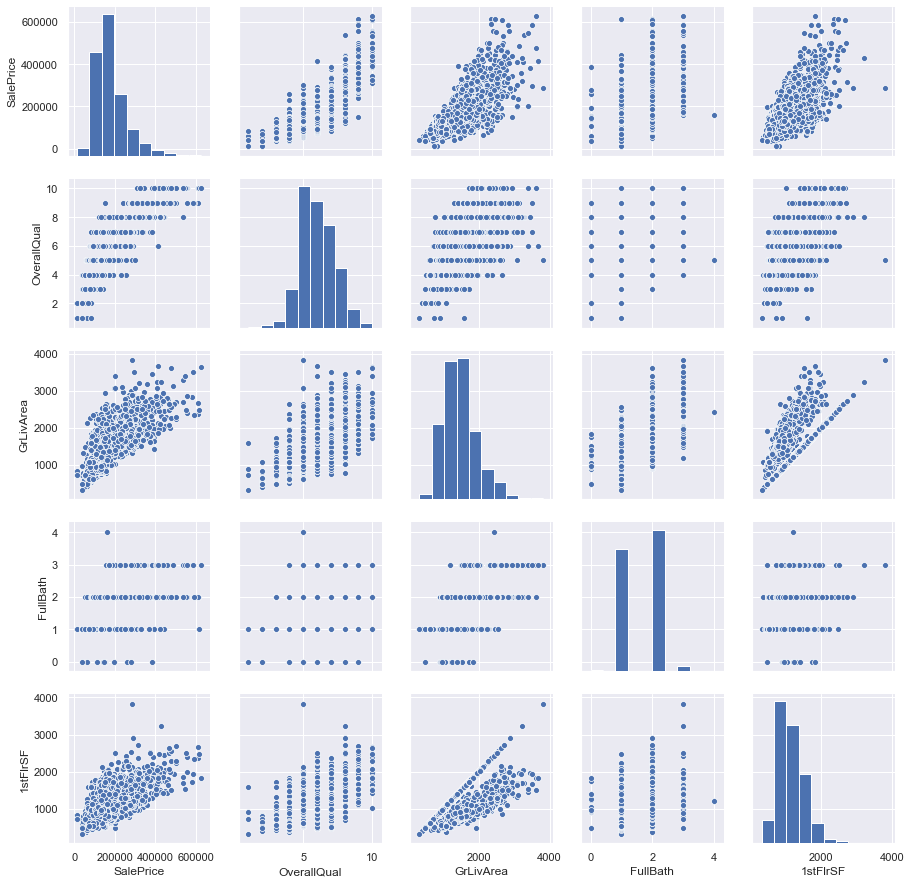

In [26]:
#Paiplot of most correlated features
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'FullBath','1stFlrSF']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

### Model Building

In [27]:
#Recreate train and test dataset from all data
df = pd.get_dummies(df) 
df_train = df[:df_train_shape]
df_test = df[df_train_shape:df_shape]
print("Shape of train data:",df_train.shape)
print("Shape of test data:",df_test.shape)
X=df_train.values

#Split the train data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

Shape of train data: (2902, 322)
Shape of test data: (1459, 322)


In [28]:
##Model Evaluation
n_folds = 10
def model_evaluate(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    print ("R^2 is: {}\nRMSE is: {}".format(model.score(X_test, y_test),rmse.mean()))
    

Training Accuracy of Linear Regression: 0.9397805444623857
RMSE score of LinearRegression: 0.11530713811284003
Testing Accuracy of Linear Regression: 1.0


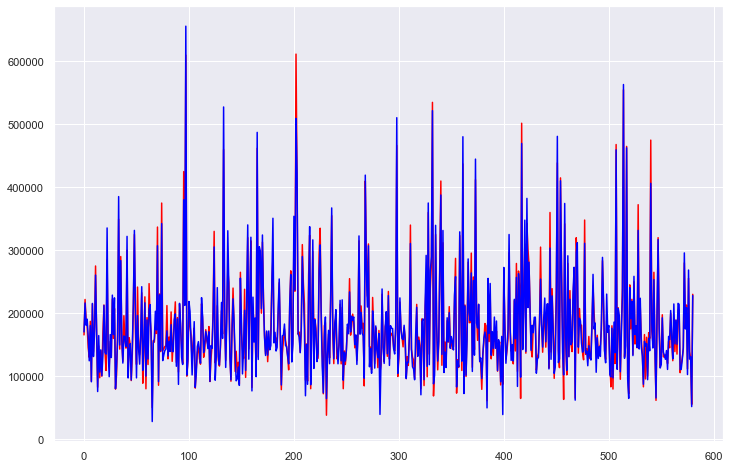

Training Accuracy of RandomForest Regression: 0.9836754766599503
RMSE score of RandomForestRegression: 0.1139642362448514
Testing Accuracy of RandomForestRegression: 0.9197003019504093


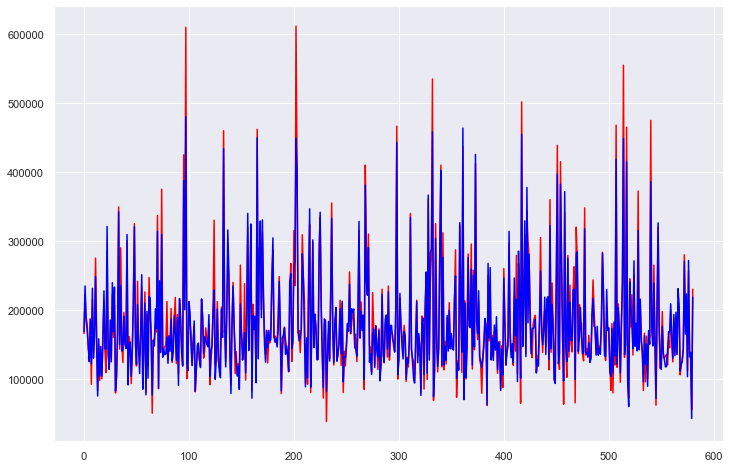

In [29]:
##LinearRegression

linearRegression = linear_model.LinearRegression()
linearRegModel=linearRegression.fit(X_train,y_train)
linear_trainscore=linearRegModel.score(X_train, y_train)
print("Training Accuracy of Linear Regression:",linear_trainscore)

# Predict new result
y_pred = linearRegModel.predict(X_test)
rms_lin=sqrt(mean_squared_error(y_test,y_pred))
print("RMSE score of LinearRegression:",rms_lin)
linear_testscore=linearRegModel.score(X_test, y_pred)
print("Testing Accuracy of Linear Regression:",linear_testscore)

# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(np.exp(y_test), color='red')
plt.plot(np.exp(y_pred), color='blue')
plt.show()

##RandomForestRegressor
rndmForestRegressorModel = RandomForestRegressor(n_estimators=300, random_state=0)
rndmForestRegressorModel.fit(X_train,y_train)
rndmFrst_trainscore=rndmForestRegressorModel.score(X_train, y_train)
print("Training Accuracy of RandomForest Regression:",rndmFrst_trainscore)

# Predict new result
y_pred_rfr = rndmForestRegressorModel.predict(X_test)
rms_rf=sqrt(mean_squared_error(y_test,y_pred_rfr))
print("RMSE score of RandomForestRegression:",rms_rf)
rndmFrst_testscore=rndmForestRegressorModel.score(X_test, y_test)

print("Testing Accuracy of RandomForestRegression:",rndmFrst_testscore)
# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(np.exp(y_test), color='red')
plt.plot(np.exp(y_pred_rfr), color='blue')
plt.show()

R2 training score of Random Forest Regression with PCA: 0.9810792073020973
RMSE score of RandomforestRegression with pca: 0.13479629340313523
R2 Training score of Linear Regression with PCA: 0.8874472885916953
RMSE score of LinearRegression with pca: 0.12708175529076673


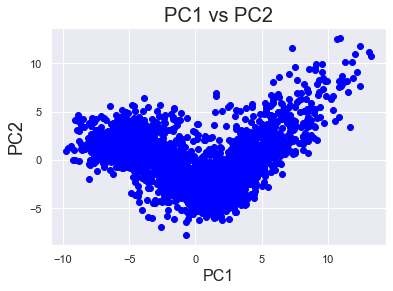

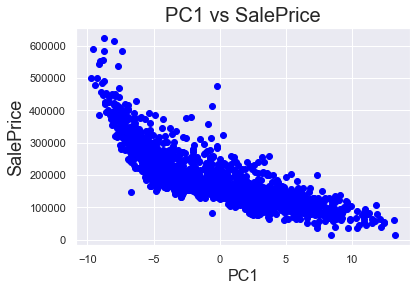

Principal components relations with features:      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
PC1    0.007274    -0.059671 -0.034014    -0.184168     0.050184  -0.190604   
PC2    0.106220    -0.060398 -0.062061     0.051667    -0.068735   0.017419   

     YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  \
PC1     -0.155997   -0.100609   -0.086574    0.003482  ...   
PC2      0.086725   -0.011958   -0.107326   -0.106281  ...   

     SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
PC1               0.024656              0.014884              0.003814   
PC2               0.030003              0.007424             -0.008182   

     SaleCondition_Normal  SaleCondition_Partial  Crime Rate_217.1  \
PC1              0.029697              -0.089799          0.008503   
PC2             -0.078612               0.097069         -0.010223   

     Crime Rate_219.6  Crime Rate_222.0  Crime Rate_247.4  Crime Rate_265.7  
PC1          0.00

In [30]:
##Dimension Reduction using PCA

##PCA with 35 components

##Standardizing the data
sc = StandardScaler() 
X_train_sc = sc.fit_transform(X_train) 
X_test_sc = sc.transform(X_test) 
data_scaled = pd.DataFrame(X_train_sc,columns = df_train.columns)

##Applying PCA
pca = PCA(n_components = 35)  
X_train_pca = pca.fit_transform(X_train_sc) 
X_test_pca = pca.transform(X_test_sc)
explained_variance = pca.explained_variance_ratio_ 

##RandomForestRegressorr +PCA
RandmForestRegressor_afterPCA = RandomForestRegressor(n_estimators=300, random_state=0)
RandmForestRegressorModel_afterPCA=RandmForestRegressor_afterPCA.fit(X_train_pca,y_train)
print("R2 training score of Random Forest Regression with PCA:",RandmForestRegressorModel_afterPCA.score(X_train_pca, y_train))

y_pred_pca_rndom = RandmForestRegressor_afterPCA.predict(X_test_pca)
rms_lin_pca_rndm=sqrt(mean_squared_error(y_test,y_pred_pca_rndom))
print("RMSE score of RandomforestRegression with pca:",rms_lin_pca_rndm)

##Linear Regression+PCA
linearRegression_afterPCA = linear_model.LinearRegression()
linearRegModel_PCA=linearRegression_afterPCA.fit(X_train_pca,y_train)
print("R2 Training score of Linear Regression with PCA:",linearRegModel_PCA.score(X_train_pca, y_train))

y_pred_pca = linearRegression_afterPCA.predict(X_test_pca)
rms_lin_pca=sqrt(mean_squared_error(y_test,y_pred_pca))
print("RMSE score of LinearRegression with pca:",rms_lin_pca)

###PCA with 2 components
pca_2cmpnts = PCA(n_components = 2) 
X_train_pca_2cmpnts = pca_2cmpnts.fit_transform(X_train_sc) 
X_test_pca_2cmpnts = pca_2cmpnts.transform(X_test_sc) 
pca_df = pd.DataFrame(data = X_train_pca_2cmpnts
             , columns = ['PC1','PC2'])
pca_df['target']=np.exp(y_train)
#Plotting PC! Vs PC2
plt.scatter(pca_df['PC1'],pca_df['PC2'],c = 'blue')
plt.title('PC1 vs PC2', fontsize=20)
plt.ylabel('PC2', fontsize=18)
plt.xlabel('PC1', fontsize=16)
plt.show()
#Plotting PC1 vs SalePrice
plt.scatter(pca_df['PC1'],pca_df['target'],c = 'blue')
plt.title('PC1 vs SalePrice', fontsize=20)
plt.ylabel('SalePrice', fontsize=18)
plt.xlabel('PC1', fontsize=16)
plt.show()

# Principal components relations with features:
print ("Principal components relations with features:",pd.DataFrame(pca_2cmpnts.components_,columns=data_scaled.columns,index = ['PC1','PC2']))



In [31]:
##Support Vector Regression Models

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

svr_rbf_model=svr_rbf.fit(X_train_sc,y_train)
svr_rbf_trainscore=svr_rbf_model.score(X_train_sc, y_train)
print("Training Accuracy of Support Vector Regression -RBF model:",svr_rbf_trainscore)

svr_rbf_testscore=svr_rbf_model.score(X_test_sc, y_test)
print("Testing Accuracy of Support Vector Regression -RBF model:",svr_rbf_testscore)

svr_poly_model=svr_poly.fit(X_train_sc,y_train)
svr_poly_trainscore=svr_poly_model.score(X_train_sc, y_train)
print("Training Accuracy of Support Vector Regression -POLY model:",svr_poly_trainscore)

svr_poly_testscore=svr_poly_model.score(X_test_sc, y_test)
print("Testing Accuracy of Support Vector Regression -POLY model:",svr_poly_testscore)
# Predict new result
y_pred_svr = svr_poly_model.predict(X_test_sc)
rms_svr=sqrt(mean_squared_error(y_test,y_pred_svr))

print("RMSE score of Support Vector Regression -POLY model:",rms_svr)





Training Accuracy of Support Vector Regression -RBF model: 0.9474259199577544
Testing Accuracy of Support Vector Regression -RBF model: 0.010489155977153719
Training Accuracy of Support Vector Regression -POLY model: 0.9701927005059965
Testing Accuracy of Support Vector Regression -POLY model: 0.9262221943105041
RMSE score of Support Vector Regression -POLY model: 0.1092381899427781


Training Accuracy of GradientBoosting Regression: 0.9991886274736858
RMSE score of GradientBoostingRegression: 0.09855464945898017
Testing Accuracy of GradientBoosting Regression: 0.9399475156546183


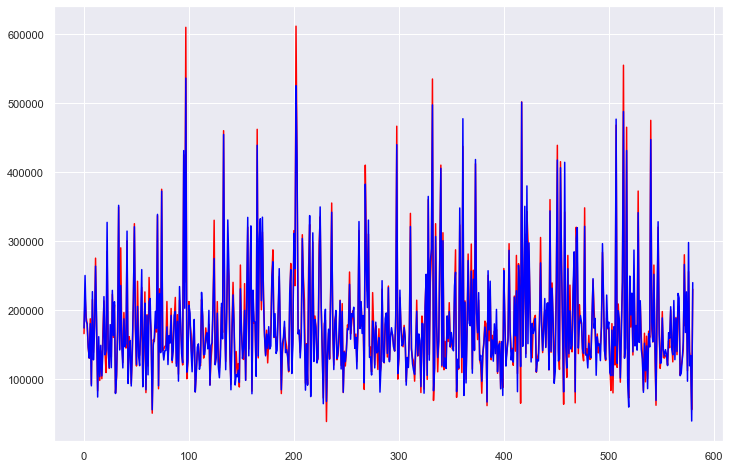

In [32]:
#GradientBoostingRegressor -tried 100,300,1000,2000,2500,3000,3500 for n_estimators

gboostRegressorModel = GradientBoostingRegressor(n_estimators=2500, random_state =0)
gboostRegressorModel.fit(X_train,y_train)
gboost_trainscore=gboostRegressorModel.score(X_train, y_train)
print("Training Accuracy of GradientBoosting Regression:",gboost_trainscore)

# Predict new result
y_pred_gbr = gboostRegressorModel.predict(X_test)
rms_gbr=sqrt(mean_squared_error(y_test,y_pred_gbr))
print("RMSE score of GradientBoostingRegression:",rms_gbr)
gboost_testscore=gboostRegressorModel.score(X_test, y_test)
print("Testing Accuracy of GradientBoosting Regression:",gboost_testscore)

# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(np.exp(y_test), color='red')
plt.plot(np.exp(y_pred_gbr), color='blue')
plt.show()

Training Accuracy of XGBoosting Regression: 0.9999871150966974
RMSE score of XGBoostingRegression: 0.10642033679251052
Testing Accuracy of XGBoosting Regression: 0.9299793719938309


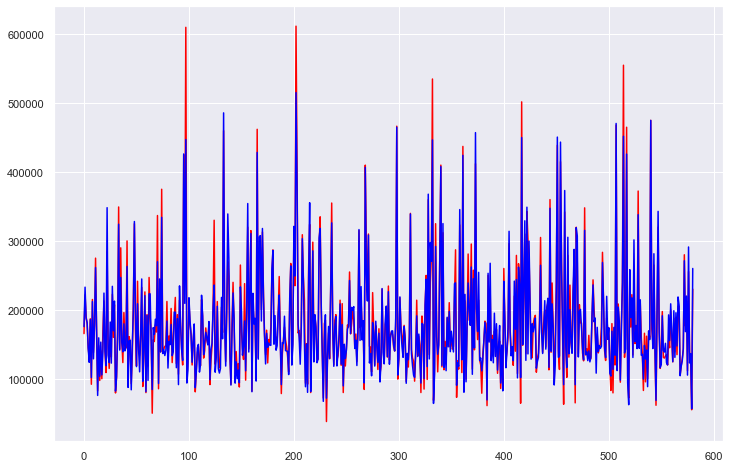

In [33]:
#XGBoost Regressor
xgboostRegressorModel = xgb.XGBRegressor( n_estimators=1000,random_state =0)
xgboostRegressorModel.fit(X_train,y_train)
xgboost_trainscore=xgboostRegressorModel.score(X_train, y_train)
print("Training Accuracy of XGBoosting Regression:",xgboost_trainscore)

# Predict new result
y_pred_xgbr = xgboostRegressorModel.predict(X_test)
rms_xgb=sqrt(mean_squared_error(y_test,y_pred_xgbr))
print("RMSE score of XGBoostingRegression:",rms_xgb)
xgboost_testscore=xgboostRegressorModel.score(X_test, y_test)
print("Testing Accuracy of XGBoosting Regression:",xgboost_testscore)

# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(np.exp(y_test), color='red')
plt.plot(np.exp(y_pred_xgbr), color='blue')
plt.show()



R2 score of lasso Regression: 0.9396623265418381
RMSE score of LassoRegression: 0.13705966338134512
Testing Accuracy of LassoRegression: 0.8838561908947483


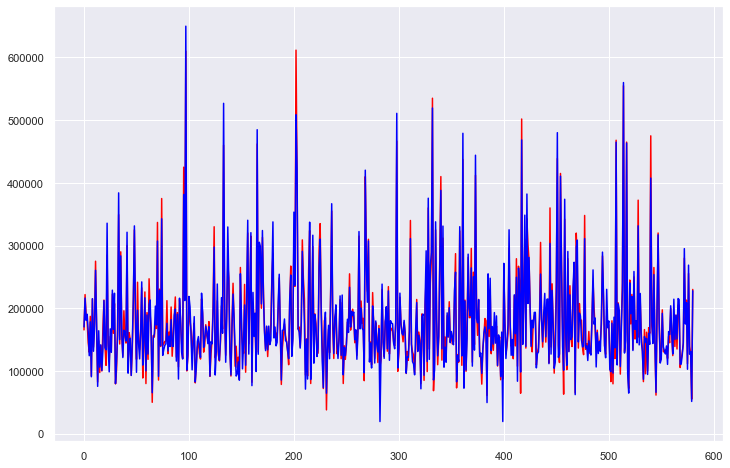

In [34]:
#Lasso regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler

robScale = RobustScaler()
robScaleXtrain = robScale.fit_transform(X_train)
robScaleXtest = robScale.transform(X_test)

model=Lasso(alpha = 0.00001, random_state=1)
model.fit(robScaleXtrain, y_train)
# Predict new result
lasso_preds = model.predict(robScaleXtest)

lasso_trainscore=model.score(robScaleXtrain, y_train)
print("R2 score of lasso Regression:",lasso_trainscore)

rms=sqrt(mean_squared_error(y_test,lasso_preds))
print("RMSE score of LassoRegression:",rms)
lasso_testscore=model.score(robScaleXtest, y_test)

print("Testing Accuracy of LassoRegression:",lasso_testscore)
# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(np.exp(y_test), color='red')
plt.plot(np.exp(lasso_preds), color='blue')
plt.show()

RMSE for LightGBM: 0.10186371939630151
Accuracy score for LightGBM:0.9358471724166508


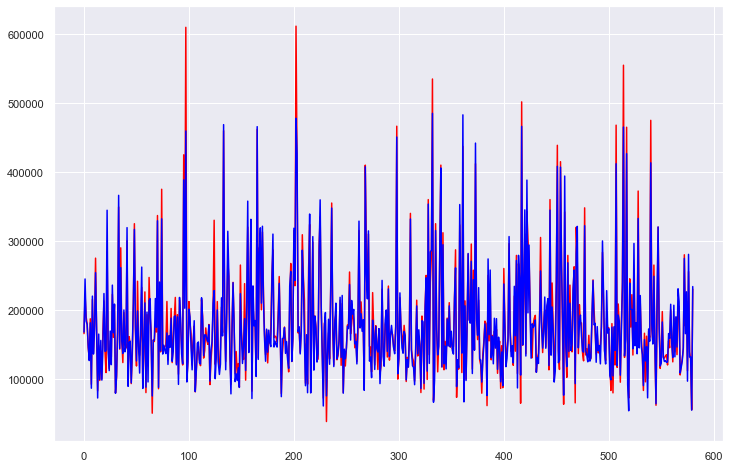

In [35]:
#LightGBM
def attempt_light_main():    
    light = lgb.LGBMRegressor()
    li = light.fit(X_train,y_train)
    y_li = li.predict(X_test)
    value = li.score(X_test,y_test)
    rmse_li = sqrt(mean_squared_error(y_li, y_test))
    print("RMSE for LightGBM: "+str(rmse_li))
    print("Accuracy score for LightGBM:"+str(value))
    
    plt.figure(figsize=(12,8))
    plt.plot(np.exp(y_test), color='red')
    plt.plot(np.exp(y_li), color='blue')
    plt.show()
    return [value, rmse_li]
LightGBM_testscore = attempt_light_main()

In [36]:
#Ridge
def attempt_ridge():    
    ridge = Ridge()
    ridge.fit(X_train,y_train)
    y_r = ridge.predict(X_test)
    value = ridge.score(X_test,y_test)
    rmse_r = sqrt(mean_squared_error(y_r, y_test))
    print("RMSE for Ridge: "+str(rmse_r))
    print("Accuracy score for Ridge:"+str(value))
    return [value, rmse_r]
ridge_testscore = attempt_ridge()

RMSE for Ridge: 0.10136368828245128
Accuracy score for Ridge:0.9364754564883877


### Comparison of Model Performance on Ames Housing Data

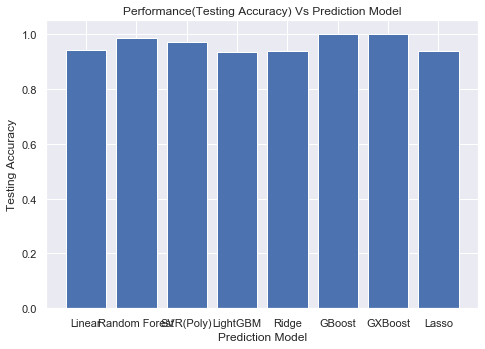

In [37]:
##Testing Accuracy
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Testing Accuracy')
ax.set_xlabel('Prediction Model')
ax.set_title('Performance(Testing Accuracy) Vs Prediction Model')
testing_models = ['Linear','Random Forest','SVR(Poly)','LightGBM', 'Ridge', 'GBoost', 'GXBoost','Lasso'];
Performance = [linear_trainscore,rndmFrst_trainscore,svr_poly_trainscore,LightGBM_testscore[0], ridge_testscore[0], gboost_trainscore, xgboost_trainscore,lasso_trainscore];
ax.bar(testing_models,Performance)
plt.show()

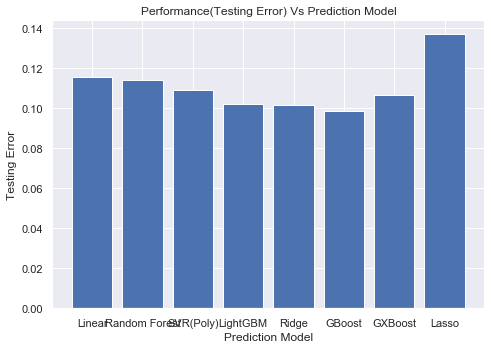

In [38]:
##Testing Errors
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Testing Error')
ax.set_xlabel('Prediction Model')
ax.set_title('Performance(Testing Error) Vs Prediction Model')
testing_models = ['Linear','Random Forest','SVR(Poly)','LightGBM', 'Ridge', 'GBoost', 'GXBoost','Lasso'];
Performance = [rms_lin,rms_rf,rms_svr,LightGBM_testscore[1], ridge_testscore[1], rms_gbr, rms_xgb,rms];
ax.bar(testing_models,Performance)
plt.show()

In [39]:
#Salesprice prediction

sub = pd.DataFrame()
sub['Id'] = test_ID
print(sub.shape)
sub['SalePrice'] = np.exp(gboostRegressorModel.predict(df_test))
sub.to_csv('results_gradientboosting.csv',index=False)


(1459, 1)


# Boston Housing Data

In [40]:
#loading boston housing data to pandas dataframe
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df_boston = pd.read_csv('housing_boston.csv', delimiter=r"\s+", names=columns)

In [41]:
#Initial preprocessing on the input file
df_boston = df_boston[~(df_boston['MEDV'] >= 50.0)]

In [42]:
df_boston.shape

(490, 14)

In [43]:
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [44]:
df_boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000
mean,3.643241,11.112245,11.113143,0.059184,0.554307,6.245471,68.27898,3.834519,9.514286,408.002041,18.520000,355.855449,12.92402,21.635918
std,8.722154,22.844626,6.821302,0.236209,0.116688,0.653147,28.16479,2.109948,8.691297,168.065190,2.110478,92.634273,7.08318,7.865301
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.90000,1.137000,1.000000,187.000000,12.600000,0.320000,1.98000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.881000,44.55000,2.111050,4.000000,280.250000,17.400000,375.912500,7.34750,16.700000
50%,0.247510,0.000000,9.690000,0.000000,0.538000,6.185000,76.80000,3.275900,5.000000,330.000000,19.100000,391.770000,11.67500,20.900000
75%,3.647422,12.500000,18.100000,0.000000,0.624000,6.578000,93.87500,5.214600,24.000000,666.000000,20.200000,396.322500,17.11750,24.675000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.00000,12.126500,24.000000,711.000000,22.000000,396.900000,37.97000,48.800000


In [45]:
#find the missing values in dataframe
missing_values_table(df_boston)

Your selected dataframe has 14 columns.
There are 0 columns that have missing values.


,Missing Values,% of Missing Values in Total Values


In [46]:
#finding correlation between features
corr = df_boston.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1,-0.2,0.41,-0.064,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.38,0.46,-0.45
ZN,-0.2,1,-0.53,-0.054,-0.51,0.31,-0.56,0.67,-0.31,-0.3,-0.38,0.18,-0.42,0.4
INDUS,0.41,-0.53,1,0.036,0.77,-0.41,0.64,-0.71,0.6,0.72,0.39,-0.36,0.64,-0.6
CHAS,-0.064,-0.054,0.036,1,0.086,0.045,0.071,-0.078,-0.033,-0.068,-0.12,0.042,-0.0065,0.075
NOX,0.42,-0.51,0.77,0.086,1,-0.32,0.73,-0.77,0.61,0.67,0.19,-0.38,0.61,-0.52
RM,-0.22,0.31,-0.41,0.045,-0.32,1,-0.27,0.25,-0.2,-0.28,-0.29,0.12,-0.61,0.69
AGE,0.35,-0.56,0.64,0.071,0.73,-0.27,1,-0.74,0.45,0.5,0.27,-0.28,0.64,-0.49
DIS,-0.38,0.67,-0.71,-0.078,-0.77,0.25,-0.74,1,-0.49,-0.53,-0.25,0.3,-0.54,0.37
RAD,0.63,-0.31,0.6,-0.033,0.61,-0.2,0.45,-0.49,1,0.91,0.46,-0.45,0.51,-0.48
TAX,0.58,-0.3,0.72,-0.068,0.67,-0.28,0.5,-0.53,0.91,1,0.45,-0.45,0.57,-0.57


In [47]:
#fing most correlated features to MEDV
corr.sort_values(["MEDV"], ascending = False, inplace = True)
print(corr.MEDV)

MEDV       1.000000
RM         0.686634
ZN         0.404608
DIS        0.368813
B          0.364928
CHAS       0.074803
CRIM      -0.450115
RAD       -0.476296
AGE       -0.492915
PTRATIO   -0.518641
NOX       -0.524451
TAX       -0.572442
INDUS     -0.600005
LSTAT     -0.759837
Name: MEDV, dtype: float64


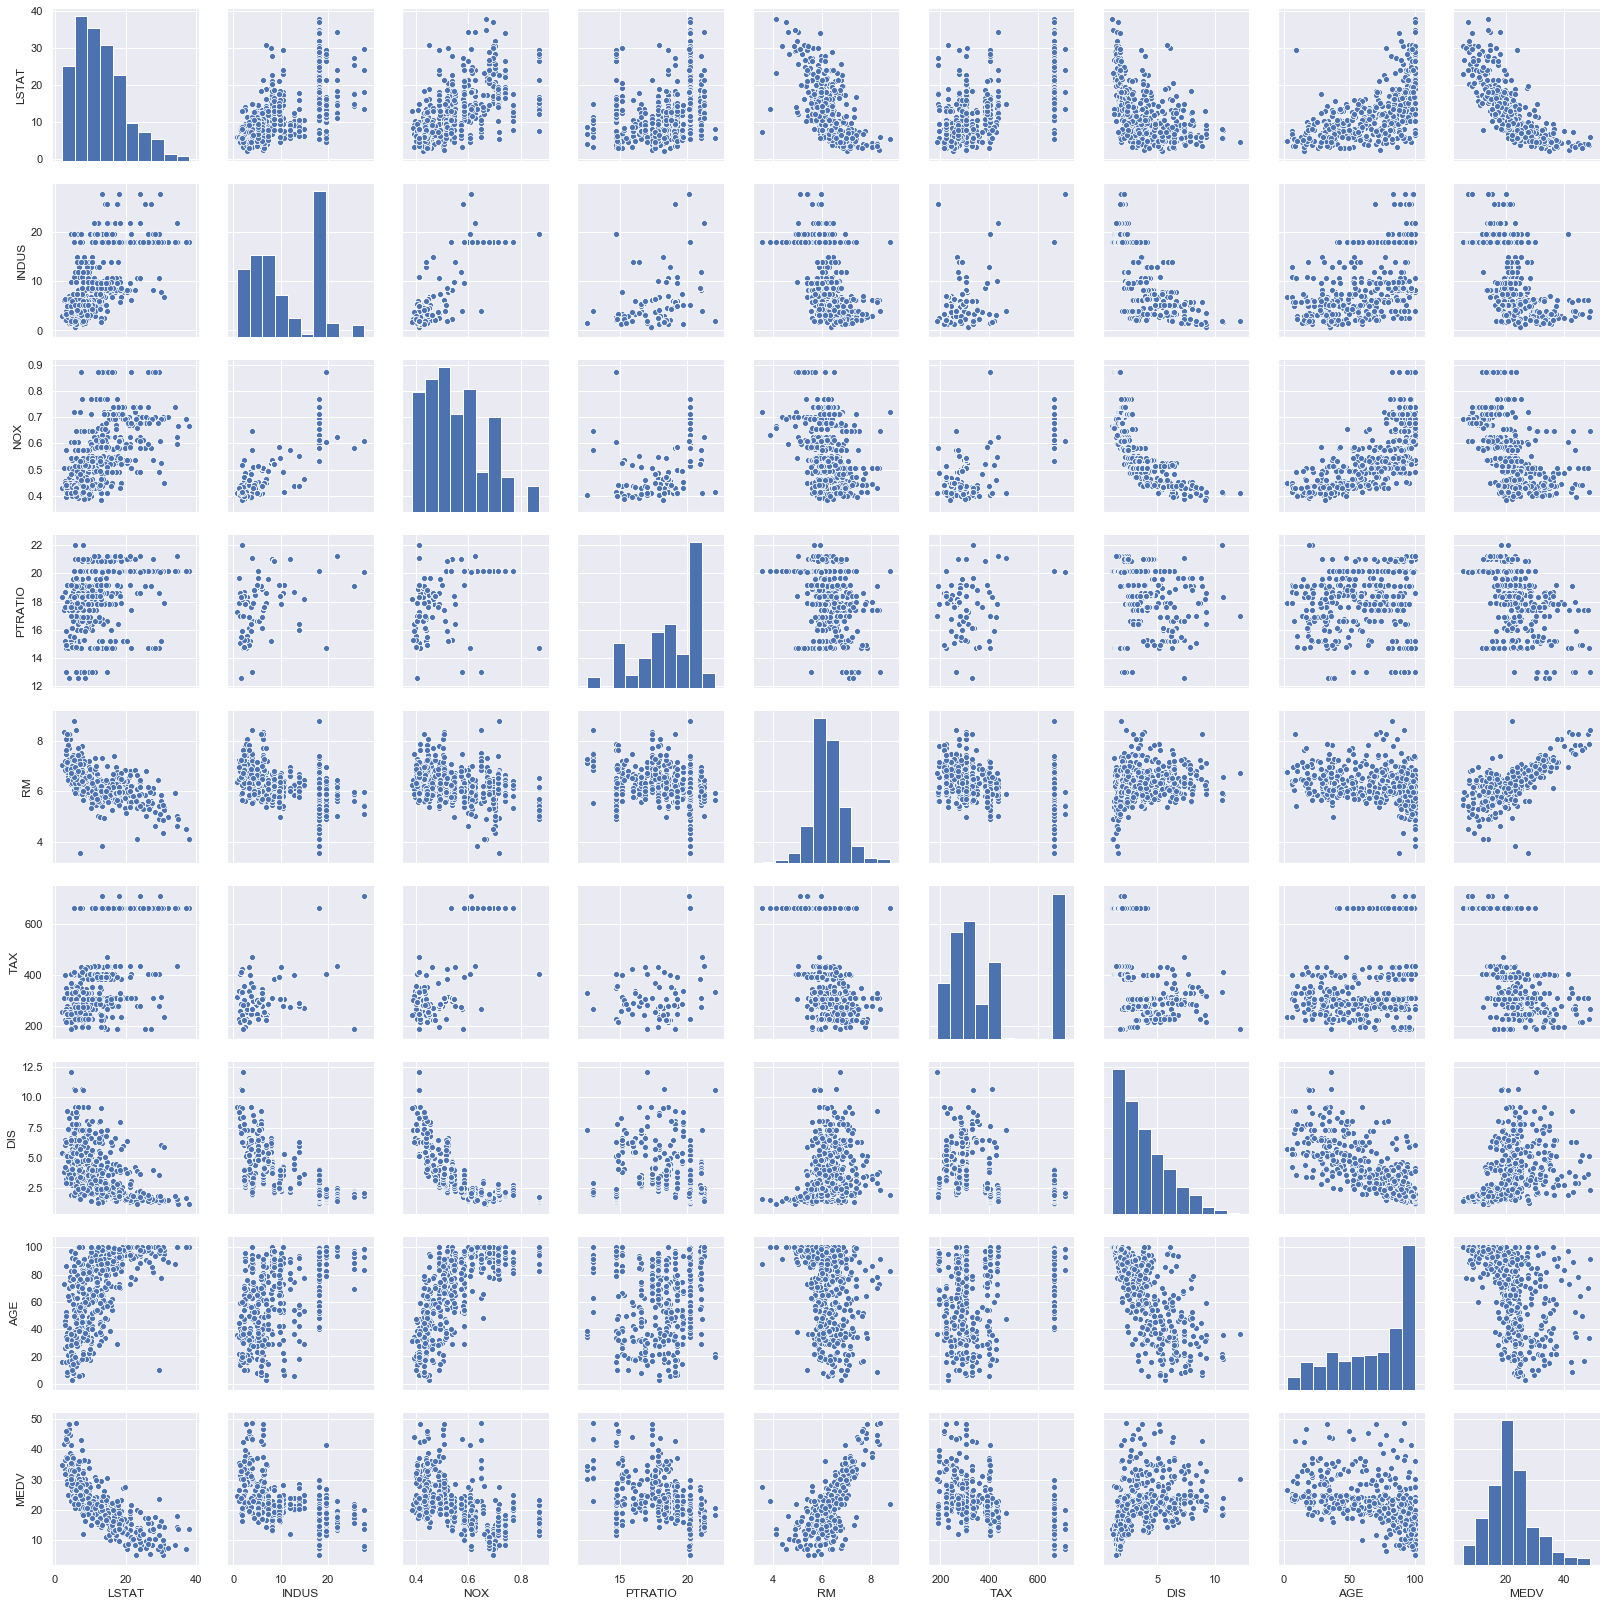

In [48]:
#Paiplot of most correlated features
sns.set()
cols = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE', 'MEDV']
sns.pairplot(df_boston[cols], size = 2.5)
plt.show();